# Capstone Project - The Battle of Neighborhoods

## Find the best place to open a Restaurant

### In a city of your choice, if someone is looking to open a restaurant, where would you recommend they open it?

## 1. Introduction

### 1.1. Business problem
The city chosen to answer the initial question is **Milan** a city in northern Italy, capital of Lombardy, and the second-most populous city in Italy after Rome. Its continuously built-up urban area, that stretches well beyond the boundaries of the administrative metropolitan city, is the fourth largest in the EU with 5.27 million inhabitants.
**Milan** is considered a leading alpha global city, with strengths in the field of the art, commerce, design, education, entertainment, fashion, finance, healthcare, media, services, research and tourism. Its business district hosts Italy's stock exchange (Italian: Borsa Italiana), and the headquarters of national and international banks and companies. In terms of GDP, it has the second-largest economy among EU cities after Paris, and is the wealthiest among EU non-capital cities. **Milan** is also considered part of the Blue Banana and one of the "*Four Motors for Europe*".

### 1.2. Target audience

* A business entrepreneur that wants open a new restaurant in Milan.
* Business Analyst or Data Scientists, who wish to analyze the neighborhoods of Milan using python, jupyter notebook and some machine learning techniques.
* Someone curious about data that want to have an idea, how beneficial it is to open a restaurant and what are the pros and cons of this business.

## 2. Data section

First step, let's install the python packages

In [49]:
!pip install wikipedia
!pip install folium 
!pip install geopy 
!pip install geopandas 
!pip install geojson
!pip install yellowbrick

and import some useful libraries

In [9]:
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import wikipedia as wp
import requests
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geopandas as gpd

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library
from folium import plugins
from folium.plugins import HeatMap

print('Libraries imported.')

Libraries imported.


First we need some information about the area of Milan such as borough, districts, population etc... I think a good place to take a look is wikipedia

In [13]:
wp.set_lang("it")
html=wp.page("Municipi_di_Milano").html()

milan_borough_wiki = pd.read_html(html)[3]

milan_borough_wiki['#'] = milan_borough_wiki['#'].str.replace('Municipio', '')

milan_borough_wiki.columns = ('Borough', 'Name', 'Area(km2)', 'Population(31/12/2018)', 'Population_Density(km2)', 'Neighborhood', 'Localizzazione')

milan_borough_wiki.drop(columns=["Localizzazione"], inplace=True)
milan_borough_wiki.drop(columns=["Neighborhood"], inplace=True)
milan_borough_wiki.drop(milan_borough_wiki.tail(1).index, inplace=True)

milan_borough_wiki

Borough                                               Name  Area(km2)  \
0       1                                     Centro storico        967   
1       2  Stazione Centrale, Gorla, Turro, Greco, Cresce...       1258   
2       3                     Città Studi, Lambrate, Venezia       1423   
3       4                                Vittoria, Forlanini       2095   
4       5                Vigentino, Chiaravalle, Gratosoglio       2987   
5       6                                Barona, Lorenteggio       1828   
6       7                        Baggio, De Angeli, San Siro       3134   
7       8                 Fiera, Gallaratese, Quarto Oggiaro       2372   
8       9                       Stazione Garibaldi, Niguarda       2112   

  Population(31/12/2018) Population_Density(km2)  
0                 98 531                  10 189  
1                162 090                  12 884  
2                144 110                  10 127  
3                161 551                   7 711  
4                126 089                   4 221  
5                151 291                   8 276  
6                175 465                   5 598  
7                188 367                   7 941  
8                187 773                   8 890

Now let's clean the dataset and add the latitude and longitude of each districts

In [4]:
geo_list = []

for x in range(1,10):
    page = requests.get('https://en.wikipedia.org/wiki/Zone_' + str(x) + '_of_Milan')
    el = BeautifulSoup(page.content, 'html.parser').find(id='coordinates').find('span', class_='geo')
    geo_list.append(el.text.split("; "))

lat, lon = zip(*geo_list)

milan_borough_wiki['Latitude'] = lat
milan_borough_wiki['Longitude'] = lon
milan_borough_wiki

Borough                                               Name  Area(km2)  \
0       1                                     Centro storico        967   
1       2  Stazione Centrale, Gorla, Turro, Greco, Cresce...       1258   
2       3                     Città Studi, Lambrate, Venezia       1423   
3       4                                Vittoria, Forlanini       2095   
4       5                Vigentino, Chiaravalle, Gratosoglio       2987   
5       6                                Barona, Lorenteggio       1828   
6       7                        Baggio, De Angeli, San Siro       3134   
7       8                 Fiera, Gallaratese, Quarto Oggiaro       2372   
8       9                       Stazione Garibaldi, Niguarda       2112   

  Population(31/12/2018) Population_Density(km2)   Latitude Longitude  
0                 98 531                  10 189  45.471282  9.184999  
1                162 090                  12 884  45.486117  9.203635  
2                144 110                  10 127  45.482506  9.241047  
3                161 551                   7 711  45.431573  9.244738  
4                126 089                   4 221  45.416987  9.238333  
5                151 291                   8 276  45.440087  9.155924  
6                175 465                   5 598  45.461244  9.089917  
7                188 367                   7 941  45.515925  9.140196  
8                187 773                   8 890  45.516888  9.191866

Download and prepare the dataset of Milan's neighborhood Source:
* https://www.pgt.comune.milano.it/sites/default/files/allegati/NIL_Intro.pdf for the link district\neighborhood
* (In wikipedia the tables aren't up to date)
https://www.mercato-immobiliare.info/lombardia/milano/milano.html and
https://www.immobiliare.it/mercato-immobiliare/lombardia/milano/ for the average land price

In [5]:
url = 'https://raw.githubusercontent.com/lazzarusd/Coursera_Capstone/master/file/Milano_Municipi_NIL.csv'
milan_borough = pd.read_csv(url)
milan_borough.rename(columns={"Num_NIL": "Num_Neighborhood", "NIL": "Neighborhood", "Municipio": "Borough", "prezzo_mq": "Average_price_sm"}, inplace=True)
milan_borough.head()

Num_Neighborhood                              Neighborhood  Borough  \
0                17                                   Adriano        2   
1                80                                    Affori        9   
2                87                                   Assiano        7   
3                55  Baggio - Q.re degli Olmi - Q.re Valsesia        7   
4                52                                Bande Nere        6   

  Average_price_sm  
0      € 2.800 /m²  
1      € 2.350 /m²  
2      € 2.400 /m²  
3      € 2.400 /m²  
4      € 3.857 /m²

Merge with wikipedia dataset

In [6]:
milan_borough['Borough'] = milan_borough['Borough'].astype(int)
milan_borough_wiki['Borough'] = milan_borough_wiki['Borough'].astype(int)

milan_borough = pd.merge(milan_borough, milan_borough_wiki, on='Borough')
milan_borough.head()

Num_Neighborhood                      Neighborhood  Borough  \
0                17                           Adriano        2   
1                16                  Gorla - Precotto        2   
2                19      Padova - Turro - Crescenzago        2   
3                10  Stazione Centrale - Ponte Seveso        2   
4                80                            Affori        9   

  Average_price_sm                                               Name  \
0      € 2.800 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
1      € 2.800 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
2      € 2.900 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
3      € 4.950 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
4      € 2.350 /m²                       Stazione Garibaldi, Niguarda   

   Area(km2) Population(31/12/2018) Population_Density(km2)   Latitude  \
0       1258                162 090                  12 884  45.486117   
1       1258                162 090                  12 884  45.486117   
2       1258                162 090                  12 884  45.486117   
3       1258                162 090                  12 884  45.486117   
4       2112                187 773                   8 890  45.516888   

  Longitude  
0  9.203635  
1  9.203635  
2  9.203635  
3  9.203635  
4  9.191866

Fortunately the statistics office of Milan create a very interesting portal about open data: https://dati.comune.milano.it/.
So I used it to get the shape file of Milan's neighborhood

In [10]:
milan_neighborhood_geodf = gpd.read_file('https://dati.comune.milano.it/dataset/e8e765fc-d882-40b8-95d8-16ff3d39eb7c/resource/9c4e0776-56fc-4f3d-8a90-f4992a3be426/download/ds964_nil_wm.geojson')
milan_neighborhood_geodf.head()

ID_NIL                                             NIL  Valido_dal  \
0      48  RONCHETTO SUL NAVIGLIO - Q.RE LODOVICO IL MORO  05/02/2020   
1      64                                          TRENNO  05/02/2020   
2      67                                        PORTELLO  05/02/2020   
3      81                                       BOVISASCA  05/02/2020   
4      84                                      PARCO NORD  05/02/2020   

  Valido_al                        Fonte  Shape_Length    Shape_Area  \
0   Vigente  Milano 2030 - PGT Approvato   8723.368714  2.406306e+06   
1   Vigente  Milano 2030 - PGT Approvato   3309.998800  4.896921e+05   
2   Vigente  Milano 2030 - PGT Approvato   3800.750663  9.096022e+05   
3   Vigente  Milano 2030 - PGT Approvato   7105.469715  1.578028e+06   
4   Vigente  Milano 2030 - PGT Approvato  11741.717005  1.532331e+06   

   OBJECTID                                           geometry  
0        89  POLYGON ((9.15422 45.43775, 9.15274 45.43887, ...  
1        90  POLYGON ((9.10623 45.49016, 9.10591 45.49084, ...  
2        91  POLYGON ((9.15636 45.48785, 9.15495 45.48852, ...  
3        92  POLYGON ((9.16803 45.52234, 9.16763 45.52272, ...  
4        93  POLYGON ((9.20040 45.52848, 9.20028 45.52846, ...

In [12]:
milan_neighborhood = milan_neighborhood_geodf[['ID_NIL', 'NIL', 'geometry']].copy()
milan_neighborhood.columns = ('Id', 'Neighborhood', 'Geometry')
milan_neighborhood['Neighborhood'] = milan_neighborhood['Neighborhood'].str.title()
milan_neighborhood.tail()

Id             Neighborhood  \
83  68                   Pagano   
84   2                    Brera   
85  33  Rogoredo - Santa Giulia   
86  17                  Adriano   
87  53              Lorenteggio   

                                             Geometry  
83  POLYGON ((9.17174 45.47619, 9.17116 45.47663, ...  
84  POLYGON ((9.19165 45.46906, 9.19204 45.46937, ...  
85  POLYGON ((9.24044 45.44427, 9.23951 45.44435, ...  
86  POLYGON ((9.26729 45.51234, 9.26730 45.51236, ...  
87  POLYGON ((9.13575 45.44969, 9.13569 45.44981, ...

In [14]:
from shapely.wkt import loads as load_wkt

centroid_list = []

for polygon in milan_neighborhood_geodf["geometry"]:
    box_str = str(polygon)
    p1 = load_wkt(box_str)
    point = p1.centroid
#     print(type(p1.centroid.x))
#     print(p1.centroid.y)
    centroid_list.append((p1.centroid.y, p1.centroid.x))

lat_centr, lon_centr = zip(*centroid_list)

milan_neighborhood['Latitude'] = lat_centr
milan_neighborhood['Longitude'] = lon_centr
milan_neighborhood.head()

Id                                    Neighborhood  \
0  48  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro   
1  64                                          Trenno   
2  67                                        Portello   
3  81                                       Bovisasca   
4  84                                      Parco Nord   

                                            Geometry   Latitude  Longitude  
0  POLYGON ((9.15422 45.43775, 9.15274 45.43887, ...  45.438460   9.137260  
1  POLYGON ((9.10623 45.49016, 9.10591 45.49084, ...  45.492822   9.101675  
2  POLYGON ((9.15636 45.48785, 9.15495 45.48852, ...  45.484490   9.153947  
3  POLYGON ((9.16803 45.52234, 9.16763 45.52272, ...  45.517433   9.156731  
4  POLYGON ((9.20040 45.52848, 9.20028 45.52846, ...  45.523514   9.184235

In [15]:
milan_borough.head()

Num_Neighborhood                      Neighborhood  Borough  \
0                17                           Adriano        2   
1                16                  Gorla - Precotto        2   
2                19      Padova - Turro - Crescenzago        2   
3                10  Stazione Centrale - Ponte Seveso        2   
4                80                            Affori        9   

  Average_price_sm                                               Name  \
0      € 2.800 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
1      € 2.800 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
2      € 2.900 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
3      € 4.950 /m²  Stazione Centrale, Gorla, Turro, Greco, Cresce...   
4      € 2.350 /m²                       Stazione Garibaldi, Niguarda   

   Area(km2) Population(31/12/2018) Population_Density(km2)   Latitude  \
0       1258                162 090                  12 884  45.486117   
1       1258                162 090                  12 884  45.486117   
2       1258                162 090                  12 884  45.486117   
3       1258                162 090                  12 884  45.486117   
4       2112                187 773                   8 890  45.516888   

  Longitude  
0  9.203635  
1  9.203635  
2  9.203635  
3  9.203635  
4  9.191866

Let's create the final input dataset

In [16]:
new_list = []

for ind1, neighborhood in milan_neighborhood.iterrows():
    for ind2, borough in milan_borough.iterrows():
        s1 = neighborhood[["Neighborhood"]].item().lower().partition(' - ')[0]
        s2 = borough[["Neighborhood"]].item().lower()
#         print(str(type(s1)) + ": " + s1 + " # " + str(type(s2)) + ": " + s2)
        if s1 in s2:
            frame = {'Id': neighborhood[["Id"]].item(), 
                     'Neighborhood': neighborhood[["Neighborhood"]].item(),
                     'Borough': borough[["Borough"]].item(),
                     'Population(31/12/2018) Borough': borough[["Population(31/12/2018)"]].item(),
                     'Average Price(€/sm)': borough[["Average_price_sm"]].item(),
                     'Latitude': neighborhood[["Latitude"]].item(),
                     'Longitude': neighborhood[["Longitude"]].item(),
                     'Geometry': neighborhood[["Geometry"]].item()
                    }
            new_list.append(frame)

cn = ['Id', 'Neighborhood', 'Borough', 'Population(31/12/2018) Borough', 'Average Price(€/sm)', 'Latitude', 'Longitude', 'Geometry']
df_milan_complete = pd.DataFrame(new_list, columns = cn)
df_milan_complete.head()

Id                                    Neighborhood  Borough  \
0  48  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro        6   
1  64                                          Trenno        8   
2  67                                        Portello        8   
3  81                                       Bovisasca        9   
4  84                                      Parco Nord        9   

  Population(31/12/2018) Borough Average Price(€/sm)   Latitude  Longitude  \
0                        151 291         € 2.563 /m²  45.438460   9.137260   
1                        188 367         € 2.350 /m²  45.492822   9.101675   
2                        188 367         € 4.300 /m²  45.484490   9.153947   
3                        187 773         € 2.000 /m²  45.517433   9.156731   
4                        187 773         € 6.800 /m²  45.523514   9.184235   

                                            Geometry  
0  POLYGON ((9.154221025150809 45.43775166985864,...  
1  POLYGON ((9.10622707748691 45.4901620817868, 9...  
2  POLYGON ((9.156361803387014 45.48785426899354,...  
3  POLYGON ((9.168034631377399 45.5223394320893, ...  
4  POLYGON ((9.200403184652478 45.5284767228649, ...

## 3. Methodology
### 3.1. Business Understanding
The aim of this project is to find the best neighborhood of Milan to open a new restaurant.

### 3.2. Analytical Approach
The total number of neighborhoods in Milan are 89 so we need to find a way to cluster them based on their similarities, that are the number and the kind of restaurant. Briefly, after some steps of Data Cleaning and Data Exploration, I will use a K-Means algorithm to extract the clusters, produce a map and make an argument on the final result.

### 3.3. Data Exploration
To explore the data, I will use “Folium” a python library that can create interactive leaflet map using coordinate data.

Create map of Milan using latitude and longitude values

In [35]:
address = 'Milano, ITALY'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Milan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Milan are 45.4668, 9.1905.



It's pretty important to use some good visualization to understand better the area

A map of Milan with centroids of every neighborhood:

In [36]:
map_milan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_milan_complete['Latitude'], 
                                           df_milan_complete['Longitude'], 
                                           df_milan_complete['Id'], 
                                           df_milan_complete['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_milan)  
    
map_milan

Another one with a geojson and shape dimensions

In [37]:
m = folium.Map([latitude, longitude], zoom_start=12)

folium.GeoJson(milan_neighborhood_geodf,
    style_function=lambda x: {
        'color' : 'red',
        'opacity': 0.6,
        'fillColor' : 'green',
        }).add_to(m)

m

Now it's time to use the foursquare API to examinate the city of Milan

In [22]:
#@title

CLIENT_ID = 'LIL05DGC4DFZHAZZ153SBOL3S3KT1MFEGMJG2HGILCFYIW2Q' # your Foursquare ID
CLIENT_SECRET = '5TRYLBT2YP2VMEIZBRCKSRY4UHNNOUXF0VUJI4WGFJXJO2GN' # your Foursquare Secret
VERSION = '20200605'
LIMIT = 100

Extract venues for each neighborhood in Milan

In [23]:
def getNearbyRestaurants(names, latitudes, longitudes, radius):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=food&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        resp = requests.get(url).json()["response"]
        
        if "groups" in resp:
            results = resp['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
milan_restaurants = getNearbyRestaurants(names=df_milan_complete['Neighborhood'],
                                         latitudes=df_milan_complete['Latitude'],
                                         longitudes=df_milan_complete['Longitude'],
                                         radius=1500)

Ok so each row is a restaurant opened in Milan

In [25]:
print(milan_restaurants.shape)
milan_restaurants.head()

(5141, 7)


Neighborhood  Neighborhood Latitude  \
0  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro               45.43846   
1  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro               45.43846   
2  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro               45.43846   
3  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro               45.43846   
4  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro               45.43846   

   Neighborhood Longitude                     Venue  Venue Latitude  \
0                 9.13726                       Mio       45.442099   
1                 9.13726              Lungolanotte       45.442546   
2                 9.13726            Osteria Ma.Si.       45.444339   
3                 9.13726              Forno Barona       45.435589   
4                 9.13726  Ristorante il Coriandolo       45.441970   

   Venue Longitude      Venue Category  
0         9.132717  Italian Restaurant  
1         9.133911  Italian Restaurant  
2         9.140705  Italian Restaurant  
3         9.151115              Bakery  
4         9.134830  Italian Restaurant

In [26]:
rest_unique = milan_restaurants.groupby(['Venue', 
                                         'Venue Latitude', 
                                         'Venue Longitude', 
                                         'Venue Category']).size().reset_index(name='Counts') 
print(rest_unique.shape)
rest_unique.head(10)

(1993, 5)


Venue  Venue Latitude  Venue Longitude  \
0  "Carmen" (ristorante - pizzeria - grill)       45.440161         9.224682   
1                             'A Tarantella       45.490889         9.233899   
2                            100 Montaditos       45.446989         9.176994   
3                            100 Montaditos       45.453823         9.163722   
4                            100 Montaditos       45.522432         9.214766   
5                                 13 Giugno       45.469227         9.215788   
6                                     150up       45.490257         9.184895   
7                 212 Hamburger & Delicious       45.454765         9.161157   
8                212 Rotisserie & Delicious       45.452686         9.201624   
9                                        22       45.474928         9.193852   

        Venue Category  Counts  
0          Pizza Place       2  
1          Pizza Place       1  
2       Sandwich Place       2  
3       Sandwich Place       2  
4       Sandwich Place       2  
5           Restaurant       2  
6               Bistro       1  
7         Burger Joint       2  
8  Fried Chicken Joint       5  
9               Bistro       1

The foursquare API can help me to find a lot of places easily but if I use two centroids that are too close, I could extract duplicates venues.

To solve this problem, I will link a unique venue with the right neighborhood using his polygon ("geometry")

In [28]:
from shapely.geometry import shape, Point

rest_list = []

for ind1, rest in rest_unique.iterrows():
    point = Point(rest[["Venue Longitude"]].item(), rest[["Venue Latitude"]].item())
    # print(point)
    for ind2, neighborhood in df_milan_complete.iterrows():
        polygon = shape(neighborhood[["Geometry"]].item())
        if (polygon.contains(point)):
            # print("match with " + str(polygon))
            frame = {'Neighborhood': neighborhood[["Neighborhood"]].item(),
                     'Neighborhood Latitude': neighborhood[["Latitude"]].item(),
                     'Neighborhood Longitude': neighborhood[["Longitude"]].item(),
                     'Venue': rest[["Venue"]].item(), 
                     'Venue Latitude': rest[["Venue Latitude"]].item(), 
                     'Venue Longitude': rest[["Venue Longitude"]].item(), 
                     'Venue Category': rest[["Venue Category"]].item()    
                    }
            rest_list.append(frame)

cn = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
      'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
milan_restaurants_unique = pd.DataFrame(rest_list, columns = cn)
milan_restaurants_unique.head()

Neighborhood  Neighborhood Latitude  \
0                      Lodi - Corvetto              45.436484   
1      Cimiano - Rottole - Q.Re Feltre              45.498250   
2  Porta Ticinese - Conca Del Naviglio              45.450475   
3  Porta Ticinese - Conca Del Naviglio              45.450475   
4                         Porta Genova              45.453967   

   Neighborhood Longitude                                     Venue  \
0                9.228446  "Carmen" (ristorante - pizzeria - grill)   
1                9.252020                             'A Tarantella   
2                9.181311                            100 Montaditos   
3                9.181311                            100 Montaditos   
4                9.161885                            100 Montaditos   

   Venue Latitude  Venue Longitude  Venue Category  
0       45.440161         9.224682     Pizza Place  
1       45.490889         9.233899     Pizza Place  
2       45.446989         9.176994  Sandwich Place  
3       45.446989         9.176994  Sandwich Place  
4       45.453823         9.163722  Sandwich Place

As you can see, I removed a lot of duplicates:

In [29]:
print(milan_restaurants.shape)
print(milan_restaurants_unique.shape)

(5141, 7)
(1852, 7)


Now let's see all the points in a map:

In [38]:
rest_map = folium.Map([latitude, longitude], zoom_start=12)

for label, lat, lng in zip(milan_restaurants_unique['Venue'], 
                           milan_restaurants_unique['Venue Latitude'], 
                           milan_restaurants_unique['Venue Longitude']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        colur='red',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        parse_html=False
    ).add_to(rest_map)

from IPython.display import display
display(rest_map)

With a group by "Neighborhood", I can easly see how many places I have.

It doesn't hurt to check it out once more.

In [39]:
resDF = milan_restaurants_unique.groupby('Neighborhood').size().reset_index(name='Counts') 
resDF.head(10)

Neighborhood  Counts
0                                   Adriano      12
1                                    Affori      23
2                                   Assiano       4
3  Baggio - Q.Re Degli Olmi - Q.Re Valsesia       9
4                                Bande Nere      50
5                                    Barona      11
6                                   Bicocca      54
7                                    Bovisa      86
8                                 Bovisasca       4
9                                     Brera      65

In [40]:
venueDF = milan_restaurants_unique.groupby('Venue Category').size().reset_index(name='Counts')
venueDF.sort_values(by=['Counts'], ascending=False).head(10)

Venue Category  Counts
45   Italian Restaurant     398
17                 Café     293
62          Pizza Place     263
65           Restaurant      92
46  Japanese Restaurant      80
8                Bakery      52
71   Seafood Restaurant      49
81     Sushi Restaurant      47
69       Sandwich Place      46
21   Chinese Restaurant      42

Let's use all the info we have to prepare the final dataset

In [41]:
milan_onehot = pd.get_dummies(milan_restaurants_unique['Venue Category'])
milan_onehot.insert(loc=0, column='Neighborhood', value=milan_restaurants_unique['Neighborhood'])
milan_grouped = milan_onehot.groupby('Neighborhood').mean().reset_index()
milan_grouped.head(10)

Neighborhood  Abruzzo Restaurant  \
0                                   Adriano                 0.0   
1                                    Affori                 0.0   
2                                   Assiano                 0.0   
3  Baggio - Q.Re Degli Olmi - Q.Re Valsesia                 0.0   
4                                Bande Nere                 0.0   
5                                    Barona                 0.0   
6                                   Bicocca                 0.0   
7                                    Bovisa                 0.0   
8                                 Bovisasca                 0.0   
9                                     Brera                 0.0   

   African Restaurant  Agriturismo  American Restaurant  \
0                 0.0          0.0             0.000000   
1                 0.0          0.0             0.000000   
2                 0.0          0.0             0.000000   
3                 0.0          0.0             0.000000   
4                 0.0          0.0             0.000000   
5                 0.0          0.0             0.000000   
6                 0.0          0.0             0.018519   
7                 0.0          0.0             0.000000   
8                 0.0          0.0             0.000000   
9                 0.0          0.0             0.000000   

   Argentinian Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop    Bakery  \
0                     0.0          0.000000        0.0         0.0  0.083333   
1                     0.0          0.000000        0.0         0.0  0.043478   
2                     0.0          0.000000        0.0         0.0  0.000000   
3                     0.0          0.000000        0.0         0.0  0.000000   
4                     0.0          0.000000        0.0         0.0  0.000000   
5                     0.0          0.000000        0.0         0.0  0.090909   
6                     0.0          0.000000        0.0         0.0  0.000000   
7                     0.0          0.000000        0.0         0.0  0.023256   
8                     0.0          0.000000        0.0         0.0  0.000000   
9                     0.0          0.015385        0.0         0.0  0.061538   

   Belgian Restaurant    Bistro  Brazilian Restaurant  Breakfast Spot  \
0                 0.0  0.000000                   0.0             0.0   
1                 0.0  0.000000                   0.0             0.0   
2                 0.0  0.000000                   0.0             0.0   
3                 0.0  0.000000                   0.0             0.0   
4                 0.0  0.000000                   0.0             0.0   
5                 0.0  0.000000                   0.0             0.0   
6                 0.0  0.000000                   0.0             0.0   
7                 0.0  0.000000                   0.0             0.0   
8                 0.0  0.000000                   0.0             0.0   
9                 0.0  0.015385                   0.0             0.0   

     Buffet  Burger Joint  Burrito Place  Cafeteria      Café  \
0  0.000000      0.000000            0.0   0.000000  0.333333   
1  0.000000      0.000000            0.0   0.000000  0.304348   
2  0.000000      0.000000            0.0   0.000000  0.000000   
3  0.000000      0.000000            0.0   0.000000  0.222222   
4  0.000000      0.000000            0.0   0.000000  0.260000   
5  0.000000      0.000000            0.0   0.000000  0.363636   
6  0.018519      0.018519            0.0   0.037037  0.185185   
7  0.000000      0.000000            0.0   0.000000  0.186047   
8  0.000000      0.000000            0.0   0.000000  0.250000   
9  0.000000      0.015385            0.0   0.000000  0.107692   

   Calabria Restaurant  Campanian Restaurant  Caribbean Restaurant  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0          

Now I need to select only the rows about restaurants.

I suppose that our stakeholders doesn't looking to open a caffè or a bakery shop

In [42]:
milan_grouped = milan_grouped[['Neighborhood', 'Italian Restaurant', 
                            'Pizza Place', 'Restaurant', 'Japanese Restaurant', 'Seafood Restaurant', 'Sandwich Place', 'Sushi Restaurant', 
                            'Chinese Restaurant', 'Bistro', 'Burger Joint', 'Asian Restaurant', 'Diner', 'Piadineria', 'Vegetarian / Vegan Restaurant', 'Kebab Restaurant', 
                            'Trattoria/Osteria', 'Breakfast Spot', 'Steakhouse', 'Mediterranean Restaurant', 'Gastropub', 'Fast Food Restaurant', 'Food Court', 'Indian Restaurant', 
                            'Food Truck', 'Noodle House', 'Argentinian Restaurant', 'Ramen Restaurant', 'American Restaurant', 'Middle Eastern Restaurant', 'Fried Chicken Joint', 
                            'Greek Restaurant', 'Korean Restaurant', 'Mexican Restaurant', 'Puglia Restaurant', 'Sicilian Restaurant', 'Dim Sum Restaurant', 'Falafel Restaurant', 
                            'Salad Place', 'Sardinian Restaurant', 'Spanish Restaurant'
                            ]]

milan_grouped.head()

Neighborhood  Italian Restaurant  Pizza Place  \
0                                   Adriano            0.250000     0.083333   
1                                    Affori            0.217391     0.173913   
2                                   Assiano            0.000000     0.000000   
3  Baggio - Q.Re Degli Olmi - Q.Re Valsesia            0.222222     0.333333   
4                                Bande Nere            0.100000     0.260000   

   Restaurant  Japanese Restaurant  Seafood Restaurant  Sandwich Place  \
0    0.000000             0.000000                0.00             0.0   
1    0.043478             0.086957                0.00             0.0   
2    0.500000             0.000000                0.00             0.0   
3    0.000000             0.111111                0.00             0.0   
4    0.060000             0.120000                0.02             0.0   

   Sushi Restaurant  Chinese Restaurant  Bistro  Burger Joint  \
0              0.00            0.000000     0.0           0.0   
1              0.00            0.043478     0.0           0.0   
2              0.00            0.000000     0.0           0.0   
3              0.00            0.000000     0.0           0.0   
4              0.02            0.000000     0.0           0.0   

   Asian Restaurant     Diner  Piadineria  Vegetarian / Vegan Restaurant  \
0               0.0  0.083333         0.0                            0.0   
1               0.0  0.000000         0.0                            0.0   
2               0.0  0.000000         0.0                            0.0   
3               0.0  0.000000         0.0                            0.0   
4               0.0  0.020000         0.0                            0.0   

   Kebab Restaurant  Trattoria/Osteria  Breakfast Spot  Steakhouse  \
0          0.000000           0.083333             0.0         0.0   
1          0.043478           0.000000             0.0         0.0   
2          0.000000           0.000000             0.0         0.0   
3          0.000000           0.000000             0.0         0.0   
4          0.000000           0.000000             0.0         0.0   

   Mediterranean Restaurant  Gastropub  Fast Food Restaurant  Food Court  \
0                      0.00   0.000000                   0.0        0.00   
1                      0.00   0.000000                   0.0        0.00   
2                      0.25   0.000000                   0.0        0.00   
3                      0.00   0.111111                   0.0        0.00   
4                      0.00   0.000000                   0.0        0.08   

   Indian Restaurant  Food Truck  Noodle House  Argentinian Restaurant  \
0                0.0        0.00           0.0                     0.0   
1                0.0        0.00           0.0                     0.0   
2                0.0        0.00           0.0                     0.0   
3                0.0        0.00           0.0                     0.0   
4                0.0        0.02           0.0                     0.0   

   Ramen Restaurant  American Restaurant  Middle Eastern Restaurant  \
0               0.0                  0.0                        0.0   
1               0.0                  0.0                        0.0   
2               0.0                  0.0                        0.0   
3               0.0                  0.0                        0.0   
4               0.0                  0.0                        0.0   

   Fried Chicken Joint  Greek Restaurant  Korean Restaurant  \
0             0.000000               0.0                0.0   
1             0.043478               0.0                0.0   
2             0.000000               0.0                0.0   
3             0.000000               0.0                0.0   
4             0.000000               0.0                0.0   

   Mexican Restaurant  Puglia Restaurant  Sicilian Restaurant  \
0                 0.0           0.083333                  0.0  

This function return the most common venues for each row

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's use it to extract the first ten venues for every neighborhood

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
milan_venues_sorted = pd.DataFrame(columns=columns)
milan_venues_sorted['Neighborhood'] = milan_grouped['Neighborhood']

for ind in np.arange(milan_grouped.shape[0]):
    milan_venues_sorted.iloc[ind, 1:] = return_most_common_venues(milan_grouped.iloc[ind, :], num_top_venues)

Milan top 10 for each neighborhoods

In [45]:
milan_venues_sorted.head(10)

Neighborhood 1st Most Common Venue  \
0                                   Adriano    Italian Restaurant   
1                                    Affori    Italian Restaurant   
2                                   Assiano            Restaurant   
3  Baggio - Q.Re Degli Olmi - Q.Re Valsesia           Pizza Place   
4                                Bande Nere           Pizza Place   
5                                    Barona            Food Court   
6                                   Bicocca    Italian Restaurant   
7                                    Bovisa    Italian Restaurant   
8                                 Bovisasca    Italian Restaurant   
9                                     Brera    Italian Restaurant   

      2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0               Pizza Place     Trattoria/Osteria     Puglia Restaurant   
1               Pizza Place   Japanese Restaurant    Chinese Restaurant   
2  Mediterranean Restaurant      Asian Restaurant            Steakhouse   
3        Italian Restaurant   Japanese Restaurant             Gastropub   
4       Japanese Restaurant    Italian Restaurant            Food Court   
5        Italian Restaurant           Pizza Place   Japanese Restaurant   
6               Pizza Place        Sandwich Place            Restaurant   
7               Pizza Place   Japanese Restaurant            Piadineria   
8                Restaurant      Asian Restaurant            Steakhouse   
9                Restaurant   Japanese Restaurant        Sandwich Place   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                 Diner          Burger Joint        Breakfast Spot   
1      Kebab Restaurant   Fried Chicken Joint            Restaurant   
2        Breakfast Spot     Trattoria/Osteria      Kebab Restaurant   
3    Dim Sum Restaurant   Sicilian Restaurant     Trattoria/Osteria   
4            Restaurant    Falafel Restaurant    Seafood Restaurant   
5     Trattoria/Osteria      Asian Restaurant        Breakfast Spot   
6      Sushi Restaurant            Steakhouse      Kebab Restaurant   
7                 Diner            Food Court      Kebab Restaurant   
8        Breakfast Spot     Trattoria/Osteria      Kebab Restaurant   
9           Pizza Place                Bistro     Indian Restaurant   

           8th Most Common Venue          9th Most Common Venue  \
0               Kebab Restaurant  Vegetarian / Vegan Restaurant   
1                 Sandwich Place               Sushi Restaurant   
2  Vegetarian / Vegan Restaurant                     Piadineria   
3               Kebab Restaurant  Vegetarian / Vegan Restaurant   
4               Sushi Restaurant                     Food Truck   
5               Kebab Restaurant  Vegetarian / Vegan Restaurant   
6                     Piadineria                          Diner   
7  Vegetarian / Vegan Restaurant                     Steakhouse   
8  Vegetarian / Vegan Restaurant                     Piadineria   
9                          Diner               Ramen Restaurant   

  10th Most Common Venue  
0             Piadineria  
1     Seafood Restaurant  
2                  Diner  
3             Piadineria  
4                  Diner  
5             Piadineria  
6    American Restaurant  
7         Sandwich Place  
8                  Diner  
9       Asian Restaurant

## 3.4. Clustering
To analyze which neighborhood of Milan is good to open a new restaurant, I will use a K-means clustering: a type of unsupervised learning, which is used when you have unlabeled data (i.e., data without defined categories or groups). The goal of this algorithm is to find groups in the data, with the number of groups represented by the variable K. The algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on feature similarity.

So the first step is identify the best “K” using a famous analytical approach: the elbow method.

Let's see:

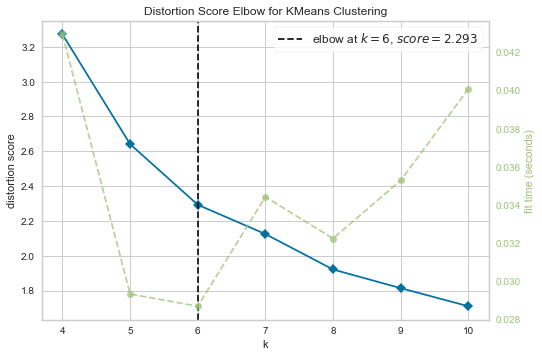

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [50]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer

milan_part_clustering = milan_grouped.drop('Neighborhood', 1)

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,11))

visualizer.fit(milan_part_clustering)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

From the plot up here, I can easily say that the best K is 6.

Now it's time to run the kmeans algorithm:

In [53]:
# set number of clusters
kclusters = 6

milan_grouped_clustering = milan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(milan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 5, 4, 5, 3, 3, 3, 5, 0, 5], dtype=int32)

Add clustering labels

In [55]:
milan_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Merge with df_milan_complete to obtain the final result

In [56]:
milan_merged = df_milan_complete.join(milan_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
milan_merged['Cluster Labels'] = milan_merged['Cluster Labels'].fillna(0)
milan_merged['Cluster Labels'] = milan_merged['Cluster Labels'].astype(int)
milan_merged.drop(columns='Geometry', inplace=True)

milan_merged.head()

Id                                    Neighborhood  Borough  \
0  48  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro        6   
1  64                                          Trenno        8   
2  67                                        Portello        8   
3  81                                       Bovisasca        9   
4  84                                      Parco Nord        9   

  Population(31/12/2018) Borough Average Price(€/sm)   Latitude  Longitude  \
0                        151 291         € 2.563 /m²  45.438460   9.137260   
1                        188 367         € 2.350 /m²  45.492822   9.101675   
2                        188 367         € 4.300 /m²  45.484490   9.153947   
3                        187 773         € 2.000 /m²  45.517433   9.156731   
4                        187 773         € 6.800 /m²  45.523514   9.184235   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               5    Italian Restaurant           Pizza Place   
1               2           Pizza Place        Sandwich Place   
2               5    Italian Restaurant   Japanese Restaurant   
3               0    Italian Restaurant            Restaurant   
4               1    Italian Restaurant  Sardinian Restaurant   

  3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue  \
0            Food Court              Noodle House      Asian Restaurant   
1    Spanish Restaurant          Asian Restaurant            Steakhouse   
2    Seafood Restaurant  Mediterranean Restaurant            Restaurant   
3      Asian Restaurant                Steakhouse        Breakfast Spot   
4            Steakhouse            Breakfast Spot     Trattoria/Osteria   

  6th Most Common Venue          7th Most Common Venue  \
0        Breakfast Spot              Trattoria/Osteria   
1        Breakfast Spot              Trattoria/Osteria   
2           Pizza Place                 Sandwich Place   
3     Trattoria/Osteria               Kebab Restaurant   
4      Kebab Restaurant  Vegetarian / Vegan Restaurant   

           8th Most Common Venue          9th Most Common Venue  \
0               Kebab Restaurant  Vegetarian / Vegan Restaurant   
1               Kebab Restaurant  Vegetarian / Vegan Restaurant   
2               Sushi Restaurant             Chinese Restaurant   
3  Vegetarian / Vegan Restaurant                     Piadineria   
4                     Piadineria                          Diner   

  10th Most Common Venue  
0             Piadineria  
1             Piadineria  
2                 Bistro  
3                  Diner  
4       Asian Restaurant

## 4. Result and Discussion
Before to start to analyze all the clusters, let’s take a look on a folium map:

In [57]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(milan_merged['Latitude'], milan_merged['Longitude'], milan_merged['Neighborhood'], milan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see, each cluster belong to a color with different characteristics.

In [58]:
milan_merged.head(10)

Id                                    Neighborhood  Borough  \
0  48  Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro        6   
1  64                                          Trenno        8   
2  67                                        Portello        8   
3  81                                       Bovisasca        9   
4  84                                      Parco Nord        9   
5  63                                          Figino        7   
6  76               Quarto Oggiaro - Vialba - Musocco        8   
7  11                                           Isola        9   
8  61                                  Quarto Cagnino        7   
9  60                              Stadio - Ippodromi        7   

  Population(31/12/2018) Borough Average Price(€/sm)   Latitude  Longitude  \
0                        151 291         € 2.563 /m²  45.438460   9.137260   
1                        188 367         € 2.350 /m²  45.492822   9.101675   
2                        188 367         € 4.300 /m²  45.484490   9.153947   
3                        187 773         € 2.000 /m²  45.517433   9.156731   
4                        187 773         € 6.800 /m²  45.523514   9.184235   
5                        175 465         € 2.000 /m²  45.491381   9.074376   
6                        188 367         € 1.700 /m²  45.513636   9.137731   
7                        187 773         € 5.550 /m²  45.490894   9.189617   
8                        175 465         € 2.241 /m²  45.473740   9.108096   
9                        175 465         € 3.265 /m²  45.479641   9.123833   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0               5    Italian Restaurant           Pizza Place   
1               2           Pizza Place        Sandwich Place   
2               5    Italian Restaurant   Japanese Restaurant   
3               0    Italian Restaurant            Restaurant   
4               1    Italian Restaurant  Sardinian Restaurant   
5               0                   NaN                   NaN   
6               2           Pizza Place    Spanish Restaurant   
7               5    Italian Restaurant           Pizza Place   
8               5    Italian Restaurant           Pizza Place   
9               3    Seafood Restaurant           Pizza Place   

  3rd Most Common Venue     4th Most Common Venue 5th Most Common Venue  \
0            Food Court              Noodle House      Asian Restaurant   
1    Spanish Restaurant          Asian Restaurant            Steakhouse   
2    Seafood Restaurant  Mediterranean Restaurant            Restaurant   
3      Asian Restaurant                Steakhouse        Breakfast Spot   
4            Steakhouse            Breakfast Spot     Trattoria/Osteria   
5                   NaN                       NaN                   NaN   
6      Asian Restaurant                Steakhouse        Breakfast Spot   
7                Bistro          Ramen Restaurant            Restaurant   
8      Sushi Restaurant          Asian Restaurant            Steakhouse   
9    Italian Restaurant  Mediterranean Restaurant            Food Truck   

  6th Most Common Venue          7th Most Common Venue  \
0        Breakfast Spot              Trattoria/Osteria   
1        Breakfast Spot              Trattoria/Osteria   
2           Pizza Place                 Sandwich Place   
3     Trattoria/Osteria               Kebab Restaurant   
4      Kebab Restaurant  Vegetarian / Vegan Restaurant   
5                   NaN                            NaN   
6     Trattoria/Osteria               Kebab Restaurant   
7    Seafood Restaurant             Chinese Restaurant   
8        Breakfast Spot              Trattoria/Osteria   
9                 Diner                   Burger Joint   

           8th Most Common Venue          9th Most Common Venue  \
0               Kebab Restaurant  Vegetarian / Vegan Restaurant   
1               Kebab Restaurant  Vegetarian / Vegan Restaurant   
2               Sushi Restaurant   

Let's take a look on the clusters

In [59]:
milan_merged.loc[milan_merged['Cluster Labels'] == 0, milan_merged.columns[[1] + list(range(4, milan_merged.shape[1]))]]

Neighborhood Average Price(€/sm)   Latitude  Longitude  \
3              Bovisasca         € 2.000 /m²  45.517433   9.156731   
5                 Figino         € 2.000 /m²  45.491381   9.074376   
10         Quinto Romano         € 2.250 /m²  45.479418   9.087541   
19            Stephenson         € 3.079 /m²  45.512246   9.121394   
21            Quintosole         € 2.910 /m²  45.403412   9.204756   
38              Muggiano         € 2.200 /m²  45.451403   9.071630   
43  Ronchetto Delle Rane         € 4.350 /m²  45.401107   9.181961   
50           Chiaravalle         € 2.700 /m²  45.416749   9.239611   
51   Parco Delle Abbazie         € 4.300 /m²  45.411618   9.205639   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
3                0    Italian Restaurant            Restaurant   
5                0                   NaN                   NaN   
10               0                   NaN                   NaN   
19               0    Italian Restaurant            Steakhouse   
21               0                   NaN                   NaN   
38               0                   NaN                   NaN   
43               0                   NaN                   NaN   
50               0    Italian Restaurant            Restaurant   
51               0    Italian Restaurant            Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3       Asian Restaurant            Steakhouse        Breakfast Spot   
5                    NaN                   NaN                   NaN   
10                   NaN                   NaN                   NaN   
19            Restaurant      Asian Restaurant        Breakfast Spot   
21                   NaN                   NaN                   NaN   
38                   NaN                   NaN                   NaN   
43                   NaN                   NaN                   NaN   
50      Asian Restaurant            Steakhouse        Breakfast Spot   
51   Japanese Restaurant      Asian Restaurant            Steakhouse   

   6th Most Common Venue 7th Most Common Venue          8th Most Common Venue  \
3      Trattoria/Osteria      Kebab Restaurant  Vegetarian / Vegan Restaurant   
5                    NaN                   NaN                            NaN   
10                   NaN                   NaN                            NaN   
19     Trattoria/Osteria      Kebab Restaurant  Vegetarian / Vegan Restaurant   
21                   NaN                   NaN                            NaN   
38                   NaN                   NaN                            NaN   
43                   NaN                   NaN                            NaN   
50     Trattoria/Osteria      Kebab Restaurant  Vegetarian / Vegan Restaurant   
51        Breakfast Spot     Trattoria/Osteria               Kebab Restaurant   

            9th Most Common Venue 10th Most Common Venue  
3                      Piadineria                  Diner  
5                             NaN                    NaN  
10                            NaN                    NaN  
19                     Piadineria                  Diner  
21                            NaN                    NaN  
38                            NaN                    NaN  
43                            NaN                    NaN  
50                     Piadineria                  Diner  
51  Vegetarian / Vegan Restaurant             Piadineria

In [60]:
milan_merged.loc[milan_merged['Cluster Labels'] == 1, milan_merged.columns[[1] + list(range(4, milan_merged.shape[1]))]]

Neighborhood Average Price(€/sm)   Latitude  Longitude  \
4          Parco Nord         € 6.800 /m²  45.523514   9.184235   
36        Ortomercato         € 4.005 /m²  45.453417   9.230270   
75  Parco Dei Navigli         € 1.800 /m²  45.423321   9.141989   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
4                1    Italian Restaurant  Sardinian Restaurant   
36               1    Italian Restaurant           Pizza Place   
75               1    Italian Restaurant  Sardinian Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
4             Steakhouse        Breakfast Spot     Trattoria/Osteria   
36      Asian Restaurant            Steakhouse        Breakfast Spot   
75            Steakhouse        Breakfast Spot     Trattoria/Osteria   

   6th Most Common Venue          7th Most Common Venue  \
4       Kebab Restaurant  Vegetarian / Vegan Restaurant   
36     Trattoria/Osteria               Kebab Restaurant   
75      Kebab Restaurant  Vegetarian / Vegan Restaurant   

            8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
4                      Piadineria                 Diner       Asian Restaurant  
36  Vegetarian / Vegan Restaurant            Piadineria                  Diner  
75                     Piadineria                 Diner       Asian Restaurant

In [61]:
milan_merged.loc[milan_merged['Cluster Labels'] == 2, milan_merged.columns[[1] + list(range(4, milan_merged.shape[1]))]]

Neighborhood Average Price(€/sm)   Latitude  \
1                              Trenno         € 2.350 /m²  45.492822   
6   Quarto Oggiaro - Vialba - Musocco         € 1.700 /m²  45.513636   
14                           Comasina         € 1.750 /m²  45.526441   
48                       Forze Armate         € 2.700 /m²  45.462489   

    Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
1    9.101675               2           Pizza Place        Sandwich Place   
6    9.137731               2           Pizza Place    Spanish Restaurant   
14   9.159969               2           Pizza Place    Spanish Restaurant   
48   9.113830               2           Pizza Place  Fast Food Restaurant   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
1     Spanish Restaurant      Asian Restaurant            Steakhouse   
6       Asian Restaurant            Steakhouse        Breakfast Spot   
14      Asian Restaurant            Steakhouse        Breakfast Spot   
48      Asian Restaurant            Steakhouse        Breakfast Spot   

   6th Most Common Venue 7th Most Common Venue          8th Most Common Venue  \
1         Breakfast Spot     Trattoria/Osteria               Kebab Restaurant   
6      Trattoria/Osteria      Kebab Restaurant  Vegetarian / Vegan Restaurant   
14     Trattoria/Osteria      Kebab Restaurant  Vegetarian / Vegan Restaurant   
48     Trattoria/Osteria      Kebab Restaurant  Vegetarian / Vegan Restaurant   

            9th Most Common Venue 10th Most Common Venue  
1   Vegetarian / Vegan Restaurant             Piadineria  
6                      Piadineria                  Diner  
14                     Piadineria                  Diner  
48                     Piadineria                  Diner

In [62]:
milan_merged.loc[milan_merged['Cluster Labels'] == 3, milan_merged.columns[[1] + list(range(4, milan_merged.shape[1]))]]

Neighborhood Average Price(€/sm)  \
9                                  Stadio - Ippodromi         € 3.265 /m²   
13                                           San Siro         € 3.150 /m²   
17                                             Farini         € 5.652 /m²   
22                                     Parco Sempione         € 5.800 /m²   
23                                             Barona         € 3.250 /m²   
25                                   Gorla - Precotto         € 2.800 /m²   
26  Niguarda - Ca' Granda - Prato Centenaro - Q.Re...         € 2.550 /m²   
27                                  Triulzo Superiore         € 2.626 /m²   
31                                          Tre Torri         € 5.986 /m²   
33                                          Morivione         € 3.595 /m²   
34                            Vigentino - Q.Re Fatima         € 3.200 /m²   
35                                            Bicocca         € 2.950 /m²   
37                                    Lodi - Corvetto         € 4.200 /m²   
42                                            Roserio         € 6.950 /m²   
44  Q.Re Gallaratese - Q.Re San Leonardo - Lampugnano         € 2.650 /m²   
46       Gratosoglio - Q.Re Missaglia - Q.Re Terrazze         € 2.250 /m²   
52                                         Bande Nere         € 3.857 /m²   
55                   Porta Vigentina - Porta Lodovica         € 6.200 /m²   
57                                         Xxii Marzo         € 5.500 /m²   
58                    Cimiano - Rottole - Q.Re Feltre         € 2.780 /m²   
59                                            Dergano         € 2.750 /m²   
68                       Maggiore - Musocco - Certosa         € 3.079 /m²   
69                                        Giambellino         € 3.717 /m²   
71                                            Corsica         € 4.747 /m²   
74                                              Sarpi         € 5.652 /m²   
78                            Rogoredo - Santa Giulia         € 2.550 /m²   

     Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
9   45.479641   9.123833               3    Seafood Restaurant   
13  45.471382   9.138358               3    Chinese Restaurant   
17  45.493963   9.174605               3    Italian Restaurant   
22  45.474131   9.176251               3    Spanish Restaurant   
23  45.432353   9.156192               3            Food Court   
25  45.512660   9.225630               3           Pizza Place   
26  45.516696   9.196117               3           Pizza Place   
27  45.427941   9.249243               3  Fast Food Restaurant   
31  45.476951   9.155728               3        Sandwich Place   
33  45.440972   9.193815               3           Pizza Place   
34  45.429521   9.201807               3           Pizza Place   
35  45.518979   9.212812               3    Italian Restaurant   
37  45.436484   9.228446               3           Pizza Place   
42  45.520248   9.122729               3    Spanish Restaurant   
44  45.496596   9.111701               3           Pizza Place   
46  45.411688   9.171188               3    Italian Restaurant   
52  45.459914   9.139080               3           Pizza Place   
55  45.450950   9.192446               3           Pizza Place   
57  45.461836   9.214330               3           Pizza Place   
58  45.498250   9.252020               3    Italian Restaurant   
59  45.502056   9.177953               3           Pizza Place   
68  45.507028   9.114640               3           Pizza Place   
69  45.447062   9.136927               3           Pizza Place   
71  45.464042   9.231143               3           Pizza Place   
74  45.483371   9.172503               3    Italian Restaurant   
78  45.436672   9.243522               3            Food Truck   

   2nd Most Common Venue 3rd Most Common Venue     4th Most Common Venue  \
9            Pizza Place    Italian Restaurant  Mediterranean Restaurant   
13           Pizza Place  

In [63]:
milan_merged.loc[milan_merged['Cluster Labels'] == 4, milan_merged.columns[[1] + list(range(4, milan_merged.shape[1]))]]

Neighborhood Average Price(€/sm)   Latitude  Longitude  Cluster Labels  \
20    Cantalupa         € 3.717 /m²  45.421741   9.157204               4   
32      Assiano         € 2.400 /m²  45.449368   9.061547               4   

   1st Most Common Venue     2nd Most Common Venue 3rd Most Common Venue  \
20            Restaurant  Mediterranean Restaurant      Asian Restaurant   
32            Restaurant  Mediterranean Restaurant      Asian Restaurant   

   4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
20            Steakhouse        Breakfast Spot     Trattoria/Osteria   
32            Steakhouse        Breakfast Spot     Trattoria/Osteria   

   7th Most Common Venue          8th Most Common Venue 9th Most Common Venue  \
20      Kebab Restaurant  Vegetarian / Vegan Restaurant            Piadineria   
32      Kebab Restaurant  Vegetarian / Vegan Restaurant            Piadineria   

   10th Most Common Venue  
20                  Diner  
32                  Diner

In [64]:
milan_merged.loc[milan_merged['Cluster Labels'] == 5, milan_merged.columns[[1] + list(range(4, milan_merged.shape[1]))]]

Neighborhood Average Price(€/sm)  \
0      Ronchetto Sul Naviglio - Q.Re Lodovico Il Moro         € 2.563 /m²   
2                                            Portello         € 4.300 /m²   
7                                               Isola         € 5.550 /m²   
8                                      Quarto Cagnino         € 2.241 /m²   
11                                              Duomo         € 7.100 /m²   
12                                          Guastalla         € 7.300 /m²   
15                                            Tibaldi          € 2.750 /m   
16                             De Angeli - Monte Rosa         € 5.986 /m²   
18                                           Bruzzano         € 2.150 /m²   
24                Villapizzone - Cagnola - Boldinasco         € 2.350 /m²   
28              Taliedo - Morsenchio - Q.Re Forlanini         € 2.950 /m²   
29                Porta Ticinese - Conca Del Naviglio         € 6.150 /m²   
30                Porta Ticinese - Conca Del Naviglio         € 6.150 /m²   
39                         Porta Ticinese - Conchetta         € 6.150 /m²   
40                         Porta Ticinese - Conchetta         € 6.150 /m²   
41                       Umbria - Molise - Calvairate         € 3.069 /m²   
45                       Padova - Turro - Crescenzago         € 2.900 /m²   
47                                      Porta Magenta         € 1.597 /m²   
49                                           Ghisolfa         € 5.652 /m²   
53                                  Lambrate - Ortica         € 3.550 /m²   
54  Stadera - Chiesa Rossa - Q.Re Torretta - Conca...         € 3.427 /m²   
56                                       Scalo Romana         € 3.595 /m²   
60           Baggio - Q.Re Degli Olmi - Q.Re Valsesia         € 2.400 /m²   
61                      Porta Garibaldi - Porta Nuova         € 7.350 /m²   
62                                             Affori         € 2.350 /m²   
63      Buenos Aires - Porta Venezia - Porta Monforte         € 6.650 /m²   
64                          Moncucco - San Cristoforo         € 1.325 /m²   
65                   Stazione Centrale - Ponte Seveso         € 4.950 /m²   
66                                             Bovisa         € 2.550 /m²   
67                                             Bovisa         € 2.000 /m²   
70                                       Porta Genova         € 6.100 /m²   
72                               Magenta - S. Vittore         € 1.597 /m²   
73                               Magenta - S. Vittore         € 5.325 /m²   
76                                             Pagano         € 8.325 /m²   
77                                              Brera         € 7.600 /m²   
79                                            Adriano         € 2.800 /m²   
80                                        Lorenteggio         € 3.100 /m²   

     Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0   45.438460   9.137260               5    Italian Restaurant   
2   45.484490   9.153947               5    Italian Restaurant   
7   45.490894   9.189617               5    Italian Restaurant   
8   45.473740   9.108096               5    Italian Restaurant   
11  45.463707   9.186948               5    Italian Restaurant   
12  45.463219   9.201891               5    Italian Restaurant   
15  45.440348   9.180459               5    Italian Restaurant   
16  45.474878   9.148412               5    Italian Restaurant   
18  45.529177   9.172134               5    Italian Restaurant   
24  45.497419   9.143523               5    Italian Restaurant   
28  45.449146   9.247377               5    Italian Restaurant   
29  45.450475   9.181311               5    Italian Restaurant   
30  45.450475   9.181311               5    Italian Restaurant   
39  45.448517   9.169242               5    Italian Restaurant   
40  45.448517   9.169242               5    Italian Restaurant   
41  45.452252   9.218898               5    Italian Restau

## 5. Conclusion
As the analysis is performed on small set of data, we can achieve better results by increasing the neighborhood information (see the next chapter). Anyway Milan is an international city with many different types of new restaurant business to offer and I think we have gone through the process of identifying the business problem, specifying the data required, clean the datasets, performing a machine learning algorithm using k-means clustering and providing some useful tips to our stakeholder.

## 6. Next Developments
Next steps I recommend would be:
* Use a different Venue API with more data. Unfortunately foursquare isn’t pretty famous in Italy. Most users prefer Google Maps or Facebook.
* Find and use updated demographics data about Milan’s Neighborhood.
* Try a Neighborhood-Based Clustering.